## Estilização da Saída do Markdown

In [1]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>


# Simulação 1 de um Conversor Buck com CPL

## 1. Importação de Bibliotecas e Implementação de Funções Utilitárias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
from control.matlab import *
import cvxpy as cp
import math
ct.use_fbs_defaults()

In [3]:
def show_matrix(name, matrix, decimal_places=2):
  """
  Apresenta uma matriz com a quantidade de casas decimais desejadas.

  Parâmetros:
  ---
  - matrix: numpy.ndarray, a matriz a ser apresentada.
  - casas_decimais: int, o número de casas decimais desejadas (padrão é 2).
  """
  pattern = "{:." + str(decimal_places) + "e}"

  def format_elem(elem):
    return pattern.format(elem)

  width = [max(map(len, map(format_elem, coluna))) for coluna in matrix.T]

  print(name, "=")

  nspaces = sum(width) + 2 * matrix.shape[1]

  print("    ┌" + " " * nspaces + "┐")
  for line in matrix:
    formatted_line = "  ".join(format_elem(e).rjust(largura)
                               for e, largura in zip(line, width))
    print("    │ " + formatted_line + " │")
  print("    └" + " " * nspaces + "┘")
  print()

In [4]:
def set_axs(axs, x, y, label, x_label, y_label, title):
  axs.plot(x, y, linestyle='-', color='black', label=label, linewidth=1.)
  axs.set_xlabel(x_label)
  axs.set_ylabel(y_label)
  axs.set_title(title)
  # axs.legend()
  axs.grid(linestyle='--')
  axs.tick_params(axis='both', direction='in', length=4, width=1,
                  colors='black', grid_alpha=1., top=True, right=True)

### 3.4 Implementação do Modelo Não-linear

In [5]:
def update_buck_nonlinear(t, x, u, params):
  # Parâmetros do sistema
  V_IN = params.get('Vin')  # Tensão de Entrada
  RL = params.get('rL')     # Resistência (indutor)
  RC = params.get('rC')     # Resistência (capacitor)
  L = params.get('L')       # Indutância
  C = params.get('C')       # Capacitância

  # Entradas do sistema: Duty Cycle e Potência da CPL
  D, P_CPL = u

  # Estados do sistema: corrente do indutor e tensão do capacitor
  IL, VC = x

  # Atualização da corrente do indutor
  diL = (V_IN / L) * D - (RL / L) * IL - VC / L

  # Atualização da tensão do capacitor
  dvC = IL / C - VC / (C * RC) - P_CPL / (C * VC)

  dx = np.array([diL, dvC])
  return dx

# Definição da saída do sistema


def output_buck_nonlinear(t, x, u, params):
  return x[0:2]


# Definição do conversor cc-cc buck nao-linear
buck_nonlinear = ct.ss(
    update_buck_nonlinear,
    output_buck_nonlinear,
    name='buck_nonlinear',
    inputs=('d', 'P_cpl'),
    outputs=('iL', 'vC'),
    states=('iL', 'vC')
)

## 4. Modelo Não-linear Trasladado

In [6]:
def update_translated_nonlinear(t, x, u, params):
  """
  Atualiza os estados do sistema não linear transladado.

  Parâmetros:
  - t: tempo
  - x: estados do sistema
  - u: entradas do sistema
  - params: parâmetros do sistema

  Retorna:
  - dx: derivadas dos estados do sistema
  """
  # Definição dos parâmetros do sistema
  V_IN = params.get('Vin')
  RL = params.get('rL')
  RC = params.get('rC')
  L = params.get('L')
  C = params.get('C')
  OP = params.get('op')

  # Definição das entradas do sistema
  δD, δP_CPL = u

  # Definição dos estados do sistema
  δIL, δVC = x

  # Atualização
  DELTA_IL_DOT = - (RL / L) * δIL - δVC / L + (V_IN / L) * δD
  DELTA_VC_DOT = - δVC / (C * RC) + δIL / C + \
      (OP['Pcpl'] * δVC - OP['vC'] * δP_CPL) / \
      (C * OP['vC'] * (OP['vC'] + δVC))

  X_DOT = np.array([DELTA_IL_DOT, DELTA_VC_DOT])

  return X_DOT


def system_output(t, x, u, params):
  """
  Calcula a saída do sistema.

  Parâmetros:
  - t: tempo
  - x: estados do sistema
  - u: entradas do sistema
  - params: parâmetros do sistema

  Retorna:
  - y: saída do sistema
  """

  return x[:2]


translated_nonlinear_system = ct.NonlinearIOSystem(
    update_translated_nonlinear, system_output,
    name='translated_nonlinear_system',
    inputs=('δd', 'δPcpl'),
    outputs=('δiL', 'δvC'),
    states=('δiL', 'δvC')
)

## 5. Simulação dos Modelos Não-lineares

In [7]:
def gen_u(timepts, values, D):
  U = np.zeros((2, len(timepts)))
  U[0, :] = D

  for i, t in enumerate(timepts):
    for j in range(len(values)-1):
      if values[j][0] <= t < values[j+1][0]:
        U[1, i] = values[j][1]
        break
    else:
      U[1, i] = values[-1][1]
  return U

In [8]:
# Parâmetros do Circuito

params = {'Vin': 48, 'rL': 0.1, 'rC': 10,
          'L': 1e-3, 'C': 2.2e-3, 'op': {'Pcpl': 50, 'vC': 28}}

# Cálculo da Corrente e Duty Cycle de Operação
op = params['op']
IL_OP = (op['vC'] / params['rC']) + op['Pcpl'] / op['vC']
D_OP = (params['rL'] * IL_OP) / params['Vin'] + op['vC'] / params['Vin']

params['op']['iL'] = IL_OP
params['op']['d'] = D_OP

# Ponto de operação de cada entrada e estado do sistema
U_OP = np.array([params['op']['d'], params['op']['Pcpl']])
X_OP = np.array([params['op']['iL'], params['op']['vC']])

step = 1e-5
timepts = np.arange(0, 1.5 + step, step)

# Entradas do Sistema
D = params['op']['d']
P_CPL = params['op']['Pcpl']


# Variação 1
values = [
    (.0, 0),
    (.1, 25),
    (.2, 50),
    (.3, 75),
    (.4, 50),
    (.5, 65),
    (.6, 30),
    (.7, 90),
    (.8, 75),
    (.9, 100),
    (1., 70),
    (1.1, 40),
    (1.2, 60),
    (1.3, 45),
    (1.4, 50),
]

U = gen_u(timepts, values, D)

# Estados Iniciais do Sistema
IL_INIT = 1.5 * params['op']['iL']
VC_INIT = 0.13 * params['op']['vC']

# IL_INIT = .95 * params['op']['iL']
# VC_INIT = .95 * params['op']['vC']
X0 = np.array([IL_INIT, VC_INIT])

δU = U - U_OP[:, np.newaxis]
δX0 = X0 - X_OP

print(δU)
print(δX0)

print('Parâmetros: ')
params

[[  0.   0.   0. ...   0.   0.   0.]
 [-50. -50. -50. ...   0.   0.   0.]]
[  2.29285714 -24.36      ]
Parâmetros: 


{'Vin': 48,
 'rL': 0.1,
 'rC': 10,
 'L': 0.001,
 'C': 0.0022,
 'op': {'Pcpl': 50,
  'vC': 28,
  'iL': 4.585714285714285,
  'd': 0.5928869047619048}}

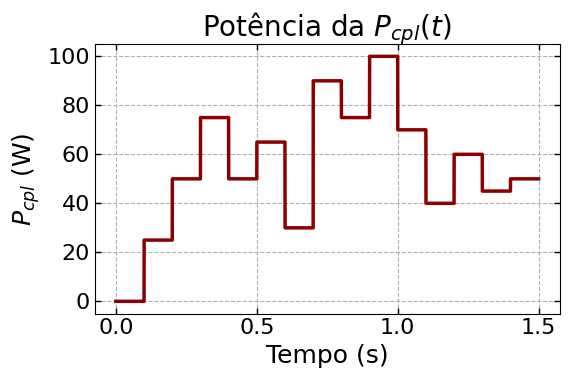

In [9]:
linewidth = 2.5

plt.figure(figsize=(6, 3.5))
plt.plot(timepts, U[1],
         linestyle='-', color='#8b0000', linewidth=linewidth, alpha=1)
# line3 = plt.axhline(y=params['op']['iL'], color='black',
#                        linestyle='-.', label='OP', linewidth=0.5)
plt.xlabel('Tempo (s)', fontsize=18)
plt.ylabel('$P_{cpl}$ (W)', fontsize=18)
plt.grid(linestyle='--')
plt.title('Potência da $P_{cpl}(t)$', fontsize=20)
plt.tick_params(axis='both', direction='in', length=4, width=1,
                colors='black', top=True, right=True, labelsize=16)

# plt.tight_layout()
plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/buck/sim2/op1/power_cpl_variation.eps', format='eps', bbox_inches='tight')

plt.show()

#### 5.2 Resposta do Sistema Não Linear

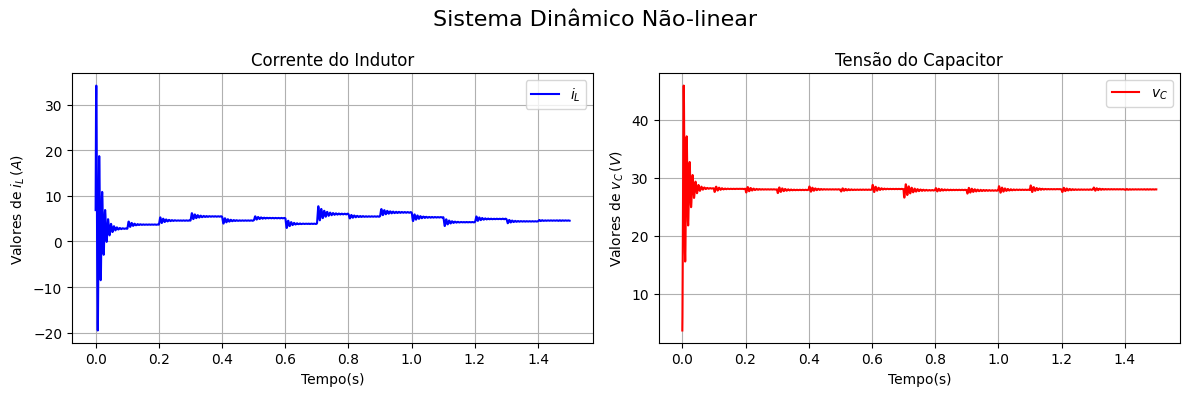

In [10]:
# Obtenção da saída
t, y_nonlinear = ct.input_output_response(
    sys=buck_nonlinear, T=timepts,
    U=U.tolist(),
    X0=X0.tolist(),
    params=params,
)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Corrente do Indutor
axs[0].plot(t, y_nonlinear[0], linestyle='-', color='b', label='$i_L$')
axs[0].set_xlabel('Tempo(s)')
axs[0].set_ylabel('Valores de $i_L\,(A)$')
axs[0].set_title('Corrente do Indutor')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2 - Tensão do Capacitor
axs[1].plot(t, y_nonlinear[1], linestyle='-', color='r', label='$v_C$')
axs[1].set_xlabel('Tempo(s)')
axs[1].set_ylabel('Valores de $v_C\,(V)$')
axs[1].set_title('Tensão do Capacitor')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Sistema Dinâmico Não-linear', fontsize=16)

plt.tight_layout()
plt.show()

### 5.3 Resposta do Sistema Não-linear Transladado

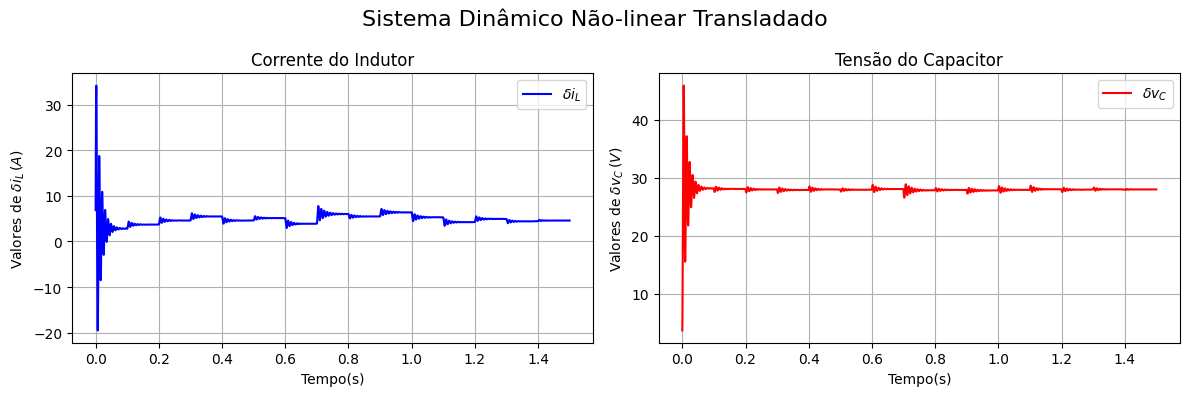

In [11]:
# Obtenção da Saída do Sistema Não-Linear Trasladado
t, y_translated_nonlinear = ct.input_output_response(
    sys=translated_nonlinear_system, T=timepts,
    U=δU.tolist(),
    X0=δX0.tolist(),
    params=params,
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': 1e-4}
)

# Criação e apresentação do gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Corrente do Indutor
axs[0].plot(
    t,
    y_translated_nonlinear[0] + params['op']['iL'],
    linestyle='-', color='b', label='$\delta i_L$'
)

axs[0].set_xlabel('Tempo(s)')
axs[0].set_ylabel('Valores de $\delta i_L\,(A)$')
axs[0].set_title('Corrente do Indutor')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2 - Tensão do Capacitor
axs[1].plot(
    t,
    y_translated_nonlinear[1] + params['op']['vC'],
    linestyle='-', color='r', label='$\delta v_C$'
)

axs[1].set_xlabel('Tempo(s)')
axs[1].set_ylabel('Valores de $\delta v_C\,(V)$')
axs[1].set_title('Tensão do Capacitor')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Sistema Dinâmico Não-linear Transladado', fontsize=16)

plt.tight_layout()
plt.show()

## 6. Modelo do Sistema Linearizado

### 6.2 Implementação do Sistema Linearizado

In [12]:
# Obtenção dos valores no ponto de operação (OP)
OP = params['op']

# Elementos da matriz de estados
A11 = - (params['rL'] / params['L'])
A12 = - (1. / params['L'])
A21 = 1. / params['C']
A22 = (1. / params['C']) * (OP['Pcpl'] /
                            (OP['vC'] * OP['vC']) - 1. / params['rC'])

# Elementos da matriz de entrada
B11 = params['Vin'] / params['L']
B12 = 0.
B21 = 0.
B22 = - 1.0 / (params['C'] * OP['vC'])

# Matriz de estados: iL e vC
A = [[A11, A12], [A21, A22]]

# Matriz de entradas: d e P_cpl
B = [[B11, B12], [B21, B22]]

# Matriz de saída: iL e vC
C = [[1., 0], [0., 1]]

# Matriz de alimentação: nula
D = [[0., 0.], [0., 0.]]

buck_linearized = ct.ss2io(
    ss(A, B, C, D),
    name='buck_linearized',
    inputs=('δd', 'δPcpl'),
    outputs=('δiL', 'δvC'),
    states=('δiL', 'δvC')
)

### 6.3 Simulação do Sistema Linearizado

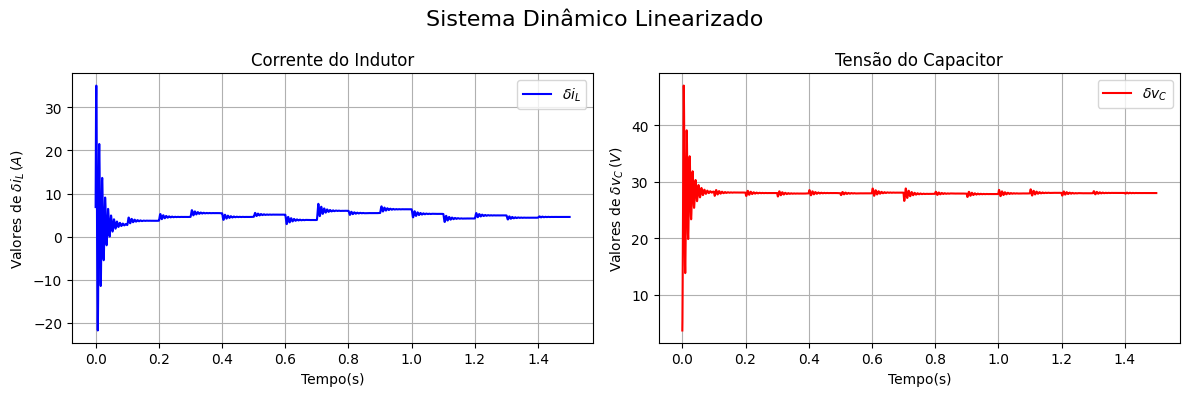

In [13]:
# Obtenção da Saída do Sistema Não-Linear Trasladado
t, y_linear = ct.input_output_response(
    sys=buck_linearized, T=timepts,
    U=δU.tolist(),
    X0=δX0.tolist(),
)

# Criação e apresentação do gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Corrente do Indutor
axs[0].plot(
    t,
    y_linear[0] + OP['iL'],
    linestyle='-', color='b', label='$\delta i_L$'
)

axs[0].set_xlabel('Tempo(s)')
axs[0].set_ylabel('Valores de $\delta i_L\,(A)$')
axs[0].set_title('Corrente do Indutor')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2 - Tensão do Capacitor
axs[1].plot(
    t,
    y_linear[1] + OP['vC'],
    linestyle='-', color='r', label='$\delta v_C$'
)

axs[1].set_xlabel('Tempo(s)')
axs[1].set_ylabel('Valores de $\delta v_C\,(V)$')
axs[1].set_title('Tensão do Capacitor')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Sistema Dinâmico Linearizado', fontsize=16)

plt.tight_layout()
plt.show()

#### 7. Comparação dos Resultados Obtidos na Simulação

Nesta seção, exploramos visualmente o comportamento do sistema através de gráficos. A biblioteca Matplotlib é utilizada para criar visualizações que representam a resposta do sistema ao longo do tempo.

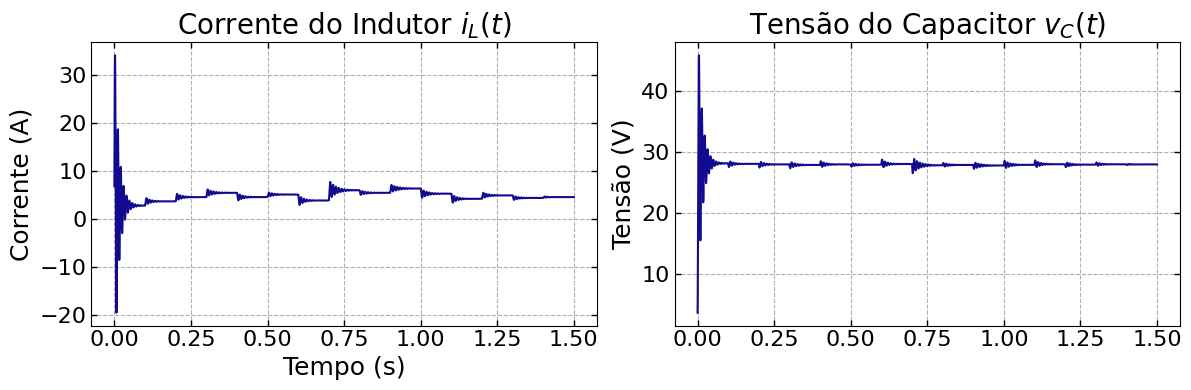

In [14]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

linewidth = 1.5

# Plotando o primeiro gráfico para a corrente do indutor
line1, = axs[0].plot(t, y_translated_nonlinear[0] + params['op']['iL'],
                     linestyle='-', color='#120a8f', linewidth=linewidth, alpha=1)

# line2, = axs[0].plot(t, y_linear[0] + params['op']['iL'], linestyle='-',
#                      color='#8b0000', linewidth=linewidth, alpha=1)

axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('Corrente (A)', fontsize=18)
axs[0].grid(linestyle='--')
axs[0].set_title('Corrente do Indutor $i_L(t)$', fontsize=20)
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Plotando o segundo gráfico para a tensão do capacitor

axs[1].plot(t, y_translated_nonlinear[1] + params['op']['vC'],
            linestyle='-', color='#120a8f', label='Não linear Transladado', linewidth=linewidth)

# axs[1].plot(t, y_linear[1] + params['op']['vC'], linestyle='-',
#             color='#8b0000', label='Linearizado', linewidth=linewidth)

# axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('Tensão (V)', fontsize=18)
axs[1].grid(linestyle='--')
axs[1].set_title('Tensão do Capacitor $v_C(t)$', fontsize=20)
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Criando uma única legenda para ambos os subplots
# fig.legend([line1, line2], ['Não Linear', 'Linearizado'],
#            fontsize=18, loc='upper center', bbox_to_anchor=(.5, 0.0), fancybox=False, shadow=False, ncol=2)

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/buck/sim2/op1/result_nonlinear.eps', format='eps', bbox_inches='tight')

## 7. Implementação dos ETM Estático e Dinâmico

Nesta seção, apresentamos o modelo de ETM dinâmico e estático proposto por Coutinho, que será utilizado neste projeto. Este modelo se baseia em uma condição suficiente para permitir o projeto simultâneo do ETM e do controlador com ganhos escalonados, garantindo a estabilidade assintótica da origem do sistema em malha fechada. Além disso, aborda um problema de otimização visando a ampliação dos intervalos entre eventos, com o objetivo de minimizar a quantidade de eventos gerados pelo ETM.

In [15]:
# Definição dos parâmetros do problema de otimização
A = cp.Parameter((2, 2),
                 value=np.array([[A11, A12], [A21, A22]]))
BU = cp.Parameter((2, 1), value=np.array([[B11], [B12]]))
I = cp.Parameter((2, 2), name='I', value=np.identity(2))

# Definição das variáveis do problema de otimização
Ξ_TIL = cp.Variable((2, 2), name='Ξ_TIL', PSD=True)
Ψ_TIL = cp.Variable((2, 2), name='Ψ_TIL', PSD=True)
X = cp.Variable((2, 2), name='X', PSD=True)
K_TIL = cp.Variable((1, 2), name='K_TIL')

_lambda = .5

# Definição do problema: objetivo e restrições
obj = cp.Minimize(cp.trace(_lambda * Ξ_TIL + (1 - _lambda) * Ψ_TIL))

M11 = A @ X + BU @ K_TIL + X @ A.T + K_TIL.T @ BU.T
M12 = BU @ K_TIL
M13 = X

M21 = K_TIL.T @ BU.T
M22 = -Ξ_TIL
M23 = np.zeros(shape=(2, 2))

M31 = X
M32 = np.zeros(shape=(2, 2))
M33 = -Ψ_TIL

M = cp.bmat([[M11, M12, M13],
             [M21, M22, M23],
             [M31, M32, M33]])

print(M.shape)
constraints = [M << 0]
constraints += [1e-9 * np.eye(2) <= Ξ_TIL]
constraints += [Ξ_TIL <= 1e9 * np.eye(2)]
constraints += [1e-9 * np.eye(2) <= Ψ_TIL]
constraints += [Ψ_TIL <= 1e9 * np.eye(2)]
prob = cp.Problem(obj, constraints)

# Resolução do problema usando o solver MOSEK
prob.solve(solver=cp.MOSEK, verbose=False)

K = None
Ξ = None
Ψ = None
P = None

# Apresentação dos Resultados
if prob.status not in ["infeasible", "unbounded"]:
  print("Valor ótimo: %s\n" % prob.value)
  for variable in prob.variables():
    if len(variable.shape) == 2:
      show_matrix(variable.name(), variable.value)
    else:
      print(variable.name(), '=', variable.value, '\n')

  X_INV = np.linalg.inv(X.value)
  Ξ = X_INV @ Ξ_TIL.value @ X_INV

  _K = K_TIL @ X_INV
  K = _K.value

  show_matrix('K', K)

  Ψ = np.linalg.inv(Ψ_TIL.value)
  P = X_INV

  show_matrix('P', P)
  show_matrix('Ξ', Ξ),
  show_matrix('Ψ', Ψ),
else:
  print('O problema não é factível')

(6, 6)
Valor ótimo: 9.511608773399415e-09

Ξ_TIL =
    ┌                      ┐
    │  2.32e-09  -3.06e-24 │
    │ -3.06e-24   1.97e-09 │
    └                      ┘

Ψ_TIL =
    ┌                      ┐
    │  7.81e-09  -8.48e-25 │
    │ -8.48e-25   6.93e-09 │
    └                      ┘

X =
    ┌                      ┐
    │  7.22e-07  -1.98e-08 │
    │ -1.98e-08   3.30e-07 │
    └                      ┘

K_TIL =
    ┌                     ┐
    │ -2.07e-13  1.39e-13 │
    └                     ┘

K =
    ┌                     ┐
    │ -2.76e-07  4.05e-07 │
    └                     ┘

P =
    ┌                    ┐
    │ 1.39e+06  8.30e+04 │
    │ 8.30e+04  3.03e+06 │
    └                    ┘

Ξ =
    ┌                    ┐
    │ 4.47e+03  7.63e+02 │
    │ 7.63e+02  1.81e+04 │
    └                    ┘

Ψ =
    ┌                    ┐
    │ 1.28e+08  1.57e-08 │
    │ 1.57e-08  1.44e+08 │
    └                    ┘




### Modelo de ETM Dinâmico Proposto

In [16]:
zero = 0
event_times_linear = [0.]


def get_gama(current_states, last_states_sent):
  error = last_states_sent - current_states
  return current_states.T @ Ψ @ current_states - error.T @ Ξ @ error


def etm_output(t, x, u, params):
  global zero, event_times_linear

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = Γ < 0

  if etm_output.first_simulation and trigger:
    event_times_linear.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [state_to_sent[0], state_to_sent[1]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.ss(
    None, etm_output,
    name='etm',
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('x1', 'x2'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.last_states_sent = zoh_output.previous
    zoh_output.previous_time = t
  zoh_output.previous = u
  return zoh_output.last_states_sent


zoh_output.previous_time = 0
zoh_output.second_simulation = False
zoh_output.previous = []
zoh_output.last_states_sent = δX0.tolist()

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.ss(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

CLOSED_LOOP_BUCK_SYSTEM = ct.interconnect(
    (buck_linearized, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('buck_linearized.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'buck_linearized.δiL'),
        ('etm.x2', 'buck_linearized.δvC'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='closed_loop_buck_system',
    inplist=('buck_linearized.δPcpl'),
    outlist=('buck_linearized.δiL',
             'buck_linearized.δvC',
             'buck_linearized.δd',
             ),
    output=('δiL', 'δvC', 'u')
)

print(CLOSED_LOOP_BUCK_SYSTEM)
print('')

step = 1e-5
timepts = np.arange(0, 1.5 + step, step)

δPcpl = δU[1]

if len(δPcpl) < len(timepts):
  diff_size = len(timepts) - len(δPcpl)
  last_value = δPcpl[-1]
  δPcpl = np.append(δPcpl, np.full(diff_size, last_value))

t, y_linear = ct.input_output_response(
    sys=CLOSED_LOOP_BUCK_SYSTEM, T=timepts,
    U=δPcpl,
    X0=δX0,
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step},
    params=params
)

inter_event_times_linear = [0.]

for i in range(1, len(event_times_linear)):
  inter_event_times_linear.append(
      event_times_linear[i] - event_times_linear[i-1])

<InterconnectedSystem>: closed_loop_buck_system
Inputs (1): ['u[0]']
Outputs (3): ['δiL', 'δvC', 'u']
States (2): ['buck_linearized_δiL', 'buck_linearized_δvC']



In [17]:
zero = 0
event_times_nonlinear = [0.]


def get_gama(current_states, last_states_sent):
  error = last_states_sent - current_states
  return current_states.T @ Ψ @ current_states - error.T @ Ξ @ error


def etm_output(t, x, u, params):
  global zero, event_times_nonlinear

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = Γ < 0

  if etm_output.first_simulation and trigger:
    event_times_nonlinear.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [state_to_sent[0], state_to_sent[1]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.ss(
    None, etm_output,
    name='etm',
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('x1', 'x2'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.last_states_sent = zoh_output.previous
    zoh_output.previous_time = t
  zoh_output.previous = u
  return zoh_output.last_states_sent


zoh_output.previous_time = 0
zoh_output.second_simulation = False
zoh_output.previous = []
zoh_output.last_states_sent = δX0.tolist()

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.ss(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

CLOSED_LOOP_BUCK_SYSTEM = ct.interconnect(
    (translated_nonlinear_system, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('translated_nonlinear_system.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'translated_nonlinear_system.δiL'),
        ('etm.x2', 'translated_nonlinear_system.δvC'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='closed_loop_buck_system',
    inplist=('translated_nonlinear_system.δPcpl'),
    outlist=('translated_nonlinear_system.δiL',
             'translated_nonlinear_system.δvC',
             'translated_nonlinear_system.δd',
             ),
    output=('δiL', 'δvC', 'u')
)

print(CLOSED_LOOP_BUCK_SYSTEM)
print('')

δPcpl = δU[1]

if len(δPcpl) < len(timepts):
  diff_size = len(timepts) - len(δPcpl)
  last_value = δPcpl[-1]
  δPcpl = np.append(δPcpl, np.full(diff_size, last_value))

t, y_nonlinear = ct.input_output_response(
    sys=CLOSED_LOOP_BUCK_SYSTEM, T=timepts,
    U=δPcpl,
    X0=δX0,
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step},
    params=params
)

inter_event_times_nonlinear = [0.]

for i in range(1, len(event_times_nonlinear)):
  inter_event_times_nonlinear.append(
      event_times_nonlinear[i] - event_times_nonlinear[i-1])

<InterconnectedSystem>: closed_loop_buck_system
Inputs (1): ['u[0]']
Outputs (3): ['δiL', 'δvC', 'u']
States (2): ['translated_nonlinear_system_δiL', 'translated_nonlinear_system_δvC']



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


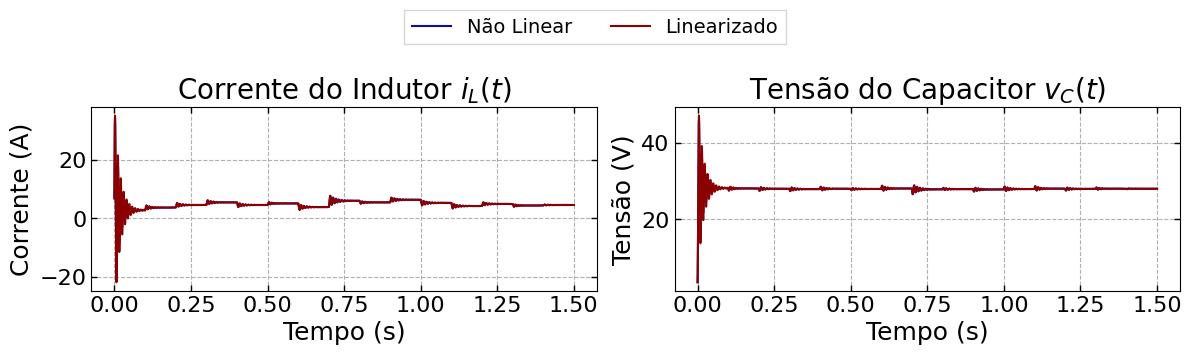

In [18]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

linewidth = 1.5

# Plotando o primeiro gráfico para a corrente do indutor
line1, = axs[0].plot(t, y_nonlinear[0] + params['op']['iL'],
                     linestyle='-', color='#120a8f', linewidth=linewidth, alpha=1)

line2, = axs[0].plot(t, y_linear[0] + params['op']['iL'], linestyle='-',
                     color='#8b0000', linewidth=linewidth, alpha=1)

axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('Corrente (A)', fontsize=18)
axs[0].grid(linestyle='--')
axs[0].set_title('Corrente do Indutor $i_L(t)$', fontsize=20)
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Plotando o segundo gráfico para a tensão do capacitor

axs[1].plot(t, y_nonlinear[1] + params['op']['vC'],
            linestyle='-', color='#120a8f', label='Não linear Transladado', linewidth=linewidth)

axs[1].plot(t, y_linear[1] + params['op']['vC'], linestyle='-',
            color='#8b0000', label='Linearizado', linewidth=linewidth)

axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('Tensão (V)', fontsize=18)
axs[1].grid(linestyle='--')
axs[1].set_title('Tensão do Capacitor $v_C(t)$', fontsize=20)
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Criando uma única legenda para ambos os subplots
fig.legend([line1, line2], ['Não Linear', 'Linearizado'],
           fontsize=14, loc='upper center', bbox_to_anchor=(.5, 1.2), fancybox=False, shadow=False, ncol=2)

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/static-etm/buck/sim2/op1/result.eps', format='eps', bbox_inches='tight')

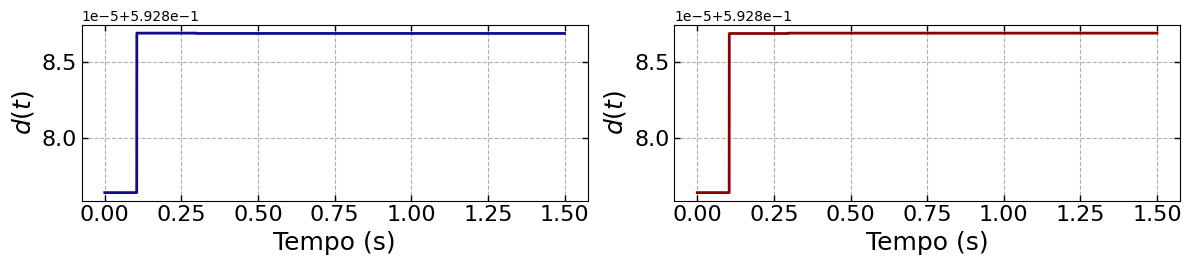

In [19]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 2.75))

linewidth = 2.

line1, = axs[0].plot(t[1:], y_nonlinear[2][1:] + params['op']['d'],
                     linestyle='-', color='#120a8f', linewidth=linewidth, alpha=1)
axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('$d(t)$', fontsize=18)
axs[0].grid(linestyle='--')
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)


line2, = axs[1].plot(t[1:], y_linear[2][1:] + params['op']['d'], linestyle='-',
                     color='#8b0000', label='Linearizado', linewidth=linewidth)

axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('$d(t)$', fontsize=18)
axs[1].grid(linestyle='--')
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)


# fig.legend([line1, line2], ['Não Linear', 'Linearizado'],
#            fontsize=14, loc='upper center', bbox_to_anchor=(.5, 1.2), fancybox=False, shadow=False, ncol=2)

# plt.suptitle(
#     'Duty Cycle $d(t)$', fontsize=18, fontweight='bold')

plt.tight_layout()

plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/static-etm/buck/sim2/op1/duty-cycle.eps', format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


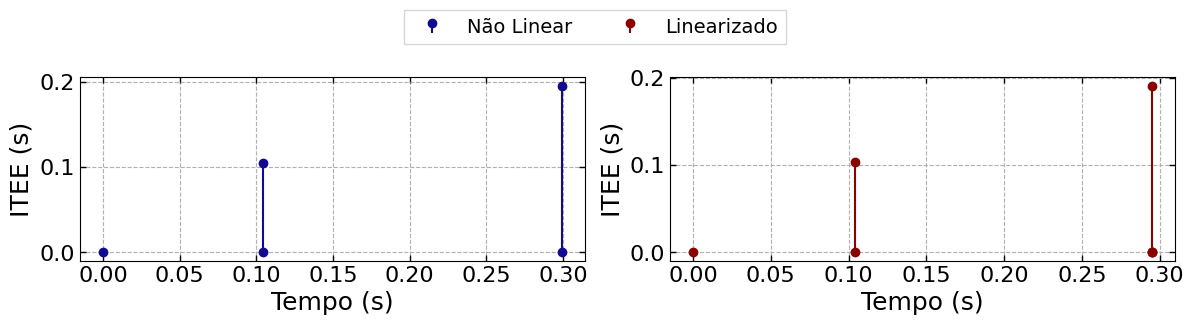

In [20]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 2.75))

linewidth = 2.

line1 = axs[0].stem(event_times_nonlinear, inter_event_times_nonlinear,
                    linefmt='#120a8f', markerfmt='o', basefmt=' ', bottom=0)
axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('ITEE (s)', fontsize=18)
axs[0].grid(linestyle='--')
# axs[0].set_title('Intervalo entre eventos', fontsize=20)
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)


line2 = axs[1].stem(event_times_linear, inter_event_times_linear,
                    linefmt='#8b0000', markerfmt='o', basefmt=' ', bottom=0)

axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('ITEE (s)', fontsize=18)
axs[1].grid(linestyle='--')
# axs[1].set_title('Intervalo entre eventos', fontsize=20)
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

fig.legend([line1, line2], ['Não Linear', 'Linearizado'],
           fontsize=14, loc='upper center', bbox_to_anchor=(.5, 1.2), fancybox=False, shadow=False, ncol=2)


plt.tight_layout()

plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/static-etm/buck/sim2/op1/inter-event-times.eps', format='eps', bbox_inches='tight')

In [21]:
def tempo_acomodacao(sinal, tempo, percentagem=2):
  valor_final = sinal[-1]  # Último valor do sinal
  limite = valor_final * (percentagem / 100)

  for i in range(len(sinal) - 1, -1, -1):
    if abs(sinal[i] - valor_final) >= limite:
      return tempo[i], i
  return tempo[0], 0


mean = np.mean(np.array(inter_event_times_nonlinear))
print(f'Média ITEE: %.3e' % mean)
mean = np.mean(np.array(inter_event_times_linear))
print(f'Média ITEE: %.3e' % mean)

ts_nonlinear_value, ts_nonlinear_idx = tempo_acomodacao(y_nonlinear[1], t)
print(f'Tempo de Acomodação (não linear): %.3e' % ts_nonlinear_value)
ts_linear_value, ts_linear_idx = tempo_acomodacao(y_linear[1], t)
print(f'Tempo de Acomodação (linear): %.3e' % ts_nonlinear_value)

Média ITEE: 5.990e-02
Média ITEE: 4.217e-02
Tempo de Acomodação (não linear): 1.500e+00
Tempo de Acomodação (linear): 1.500e+00


In [22]:
ise = np.trapz(y_nonlinear[1][:ts_nonlinear_idx] ** 2, t[:ts_nonlinear_idx])
print('ise (não linear): %.2e' % ise)

ise = np.trapz(y_linear[1][:ts_linear_idx] ** 2, t[:ts_linear_idx])
print('ise (linear): %.2e' % ise)

itse = np.trapz(t[:ts_nonlinear_idx] * y_nonlinear[1]
                [:ts_nonlinear_idx] ** 2, t[:ts_nonlinear_idx])
print('itse (não linear): %.2e' % itse)

itse = np.trapz(t[:ts_linear_idx] * y_linear[1]
                [:ts_linear_idx] ** 2, t[:ts_linear_idx])

print('itse (linear): %.2e' % itse)

isc = np.trapz((y_nonlinear[2]
               [:ts_nonlinear_idx] + OP['d']) ** 2, t[:ts_nonlinear_idx])
print('isc (não linear): %.2e' % isc)

isc = np.trapz((y_linear[2]
               [:ts_linear_idx] + + OP['d']) ** 2, t[:ts_linear_idx])

print('isc (linear): %.2e' % isc)

ise (não linear): 2.11e+00
ise (linear): 2.63e+00
itse (não linear): 4.28e-02
itse (linear): 4.82e-02
isc (não linear): 5.27e-01
isc (linear): 5.27e-01


# ETM Dinâmico

In [23]:
zero = 0
event_times_linear = [0.]

θ = 1
λ = 100


def etm_update(t, n, u, params):
  last_states_sent = u[0:2]
  current_states = u[2:4]
  Γ = get_gama(current_states, last_states_sent)
  dn = -λ * n + Γ
  return [dn]


def etm_output(t, n, u, params):
  global zero, event_times_linear

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = (n + θ * Γ) < 0

  if etm_output.first_simulation and trigger:
    event_times_linear.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [state_to_sent[0], state_to_sent[1], n[0]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.NonlinearIOSystem(
    etm_update, etm_output,
    name='etm',
    states=('n'),
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('x1', 'x2', 'n'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.lss = zoh_output.previous
    zoh_output.previous_time = t

  zoh_output.previous = u

  return zoh_output.lss


zoh_output.previous_time = 0
zoh_output.second_simulation = False
zoh_output.previous = []
zoh_output.lss = δX0.tolist()

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
    # states=1
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.NonlinearIOSystem(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

SYS = ct.interconnect(
    (buck_linearized, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('buck_linearized.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'buck_linearized.δiL'),
        ('etm.x2', 'buck_linearized.δvC'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='conversor_system',
    inplist=('buck_linearized.δPcpl'),
    outlist=('buck_linearized.δiL',
             'buck_linearized.δvC',
             'buck_linearized.δd',
             'etm.n',
             ),
    output=('δIl', 'δVc', 'u', 'n')
)

print(SYS)
print('')

δPcpl = δU[1]

t, y_linear = ct.input_output_response(
    sys=SYS, T=timepts,
    U=δPcpl,
    X0=δX0 + [0.],
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step}
)

inter_event_times_linear = [0.]

for i in range(1, len(event_times_linear)):
  inter_event_times_linear.append(
      event_times_linear[i] - event_times_linear[i-1])

<InterconnectedSystem>: conversor_system
Inputs (1): ['u[0]']
Outputs (4): ['δIl', 'δVc', 'u', 'n']
States (3): ['buck_linearized_δiL', 'buck_linearized_δvC', 'etm_n']



/home/andel/.local/lib/python3.10/site-packages/control/iosys.py:1798: UserWarning: initial state too short; padding with zeros
  warn("initial state too short; padding with zeros")


In [24]:
zero = 0
event_times_nonlinear = [0.]


def etm_update(t, n, u, params):
  last_states_sent = u[0:2]
  current_states = u[2:4]
  Γ = get_gama(current_states, last_states_sent)
  dn = -λ * n + Γ

  return [dn]


def etm_output(t, n, u, params):
  global zero, event_times_nonlinear

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = (n + θ * Γ) < 0

  if etm_output.first_simulation and trigger:
    event_times_nonlinear.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [state_to_sent[0], state_to_sent[1], n[0]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.NonlinearIOSystem(
    etm_update, etm_output,
    name='etm',
    states=('n'),
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('x1', 'x2', 'n'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.lss = zoh_output.previous
    zoh_output.previous_time = t

  zoh_output.previous = u

  return zoh_output.lss


zoh_output.previous_time = 0
zoh_output.second_simulation = False
zoh_output.previous = []
zoh_output.lss = δX0.tolist()

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
    # states=1
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.NonlinearIOSystem(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

SYS = ct.interconnect(
    (translated_nonlinear_system, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('translated_nonlinear_system.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'translated_nonlinear_system.δiL'),
        ('etm.x2', 'translated_nonlinear_system.δvC'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='conversor_system',
    inplist=('translated_nonlinear_system.δPcpl'),
    outlist=('translated_nonlinear_system.δiL',
             'translated_nonlinear_system.δvC',
             'translated_nonlinear_system.δd',
             'etm.n',
             ),
    output=('δIl', 'δVc', 'u', 'n')
)

print(SYS)
print('')

δPcpl = δU[1]

t, y_nonlinear = ct.input_output_response(
    sys=SYS, T=timepts,
    U=δPcpl,
    X0=δX0 + [0.],
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step},
    params=params
)

inter_event_times_nonlinear = [0.]

for i in range(1, len(event_times_nonlinear)):
  inter_event_times_nonlinear.append(
      event_times_nonlinear[i] - event_times_nonlinear[i-1])

<InterconnectedSystem>: conversor_system
Inputs (1): ['u[0]']
Outputs (4): ['δIl', 'δVc', 'u', 'n']
States (3): ['translated_nonlinear_system_δiL', 'translated_nonlinear_system_δvC', 'etm_n']



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


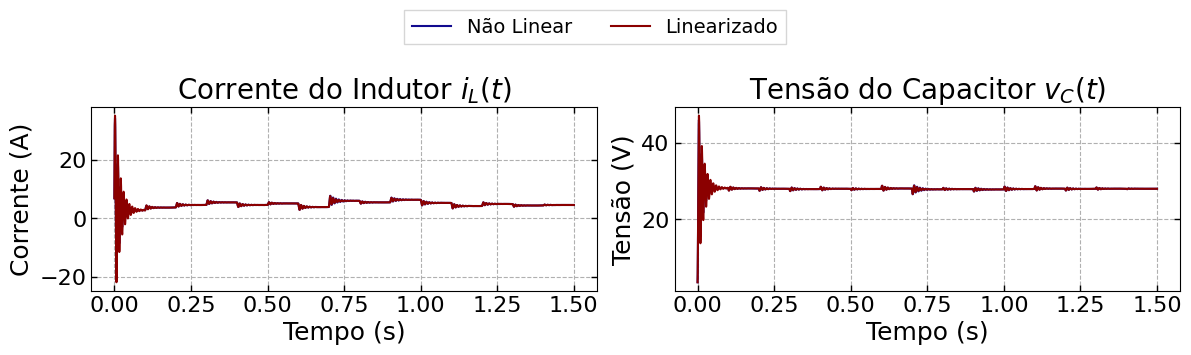

In [25]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

linewidth = 1.5

# Plotando o primeiro gráfico para a corrente do indutor
line1, = axs[0].plot(t, y_nonlinear[0] + params['op']['iL'],
                     linestyle='-', color='#120a8f', linewidth=linewidth, alpha=1)

line2, = axs[0].plot(t, y_linear[0] + params['op']['iL'], linestyle='-',
                     color='#8b0000', linewidth=linewidth, alpha=1)

axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('Corrente (A)', fontsize=18)
axs[0].grid(linestyle='--')
axs[0].set_title('Corrente do Indutor $i_L(t)$', fontsize=20)
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Plotando o segundo gráfico para a tensão do capacitor

axs[1].plot(t, y_nonlinear[1] + params['op']['vC'],
            linestyle='-', color='#120a8f', label='Não linear Transladado', linewidth=linewidth)

axs[1].plot(t, y_linear[1] + params['op']['vC'], linestyle='-',
            color='#8b0000', label='Linearizado', linewidth=linewidth)

axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('Tensão (V)', fontsize=18)
axs[1].grid(linestyle='--')
axs[1].set_title('Tensão do Capacitor $v_C(t)$', fontsize=20)
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Criando uma única legenda para ambos os subplots
fig.legend([line1, line2], ['Não Linear', 'Linearizado'],
           fontsize=14, loc='upper center', bbox_to_anchor=(.5, 1.2), fancybox=False, shadow=False, ncol=2)

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/dynamic-etm/buck/sim2/op1/result.eps', format='eps', bbox_inches='tight')

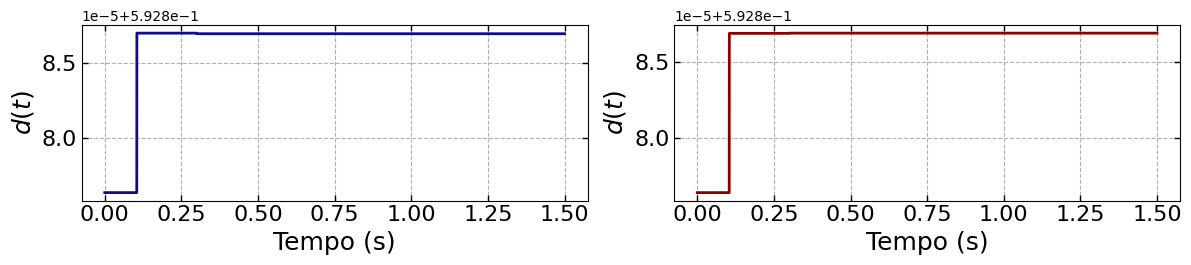

In [26]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 2.75))

linewidth = 2.

line1, = axs[0].plot(t[1:], y_nonlinear[2][1:] + params['op']['d'],
                     linestyle='-', color='#120a8f', linewidth=linewidth, alpha=1)
axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('$d(t)$', fontsize=18)
axs[0].grid(linestyle='--')
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)


line2, = axs[1].plot(t[1:], y_linear[2][1:] + params['op']['d'], linestyle='-',
                     color='#8b0000', label='Linearizado', linewidth=linewidth)

axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('$d(t)$', fontsize=18)
axs[1].grid(linestyle='--')
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)


# fig.legend([line1, line2], ['Não Linear', 'Linearizado'],
#            fontsize=14, loc='upper center', bbox_to_anchor=(.5, 1.2), fancybox=False, shadow=False, ncol=2)

# plt.suptitle(
#     'Duty Cycle $d(t)$', fontsize=18, fontweight='bold')

plt.tight_layout()

plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/dynamic-etm/buck/sim2/op1/duty-cycle.eps', format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


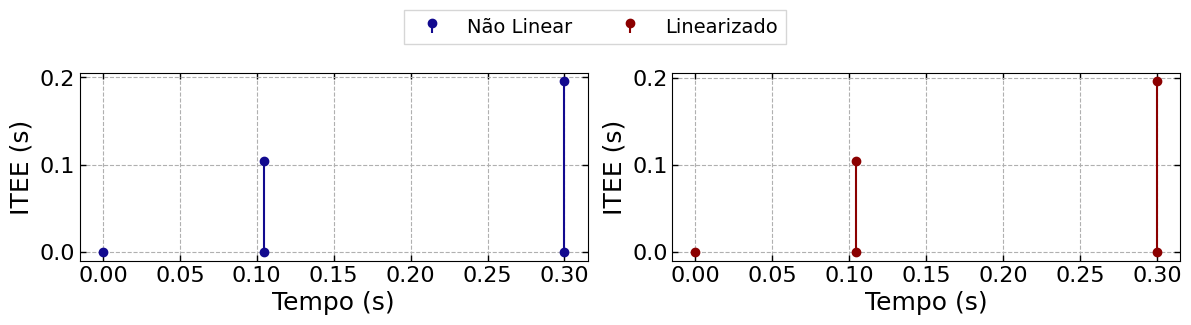

In [27]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 2.75))

linewidth = 2.

line1 = axs[0].stem(event_times_nonlinear, inter_event_times_nonlinear,
                    linefmt='#120a8f', markerfmt='o', basefmt=' ', bottom=0)
axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('ITEE (s)', fontsize=18)
axs[0].grid(linestyle='--')
# axs[0].set_title('Intervalo entre eventos', fontsize=20)
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)


line2 = axs[1].stem(event_times_linear, inter_event_times_linear,
                    linefmt='#8b0000', markerfmt='o', basefmt=' ', bottom=0)

axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('ITEE (s)', fontsize=18)
axs[1].grid(linestyle='--')
# axs[1].set_title('Intervalo entre eventos', fontsize=20)
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

fig.legend([line1, line2], ['Não Linear', 'Linearizado'],
           fontsize=14, loc='upper center', bbox_to_anchor=(.5, 1.2), fancybox=False, shadow=False, ncol=2)


plt.tight_layout()

plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/dynamic-etm/buck/sim2/op1/inter-event-times.eps', format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


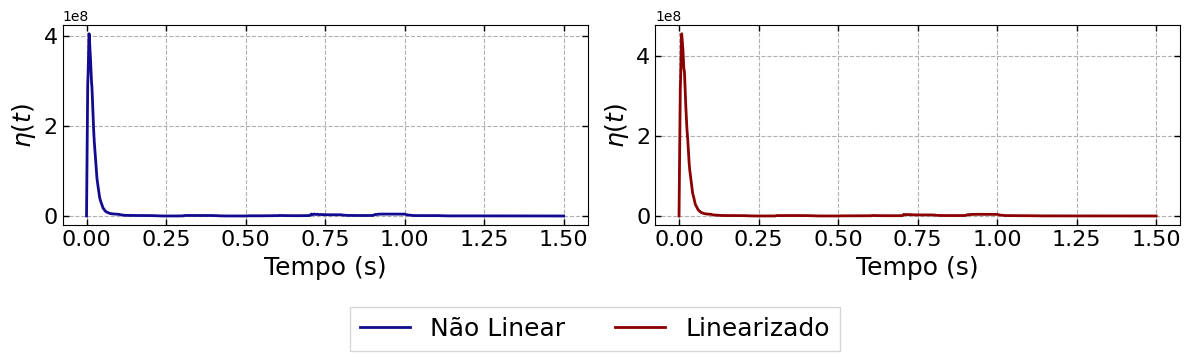

In [28]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

linewidth = 2.

line1, = axs[0].plot(t, y_nonlinear[3],
                     linestyle='-', color='#120a8f', linewidth=linewidth, alpha=1)
axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('$\eta(t)$', fontsize=18)
axs[0].grid(linestyle='--')
# axs[0].set_title('$\eta(t)$  $d(t)$', fontsize=20)
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)
# axs[0].ticklabel_format(style='plain')


line2, = axs[1].plot(t, y_linear[3], linestyle='-',
                     color='#8b0000', label='Linearizado', linewidth=linewidth)

axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('$\eta(t)$', fontsize=18)
axs[1].grid(linestyle='--')
# axs[1].set_title('Duty Cycle  $d(t)$', fontsize=20)
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)
# axs[1].ticklabel_format(style='plain')


fig.legend([line1, line2], ['Não Linear', 'Linearizado'],
           fontsize=18, loc='upper center', bbox_to_anchor=(.5, 0.0), fancybox=False, shadow=False, ncol=2)

plt.tight_layout()

plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/dynamic-etm/buck/sim2/op1/eta.eps', format='eps', bbox_inches='tight')

In [29]:
def tempo_acomodacao(sinal, tempo, percentagem=2):
  valor_final = sinal[-1]  # Último valor do sinal
  limite = valor_final * (percentagem / 100)

  for i in range(len(sinal) - 1, -1, -1):
    if abs(sinal[i] - valor_final) >= limite:
      return tempo[i], i
  return tempo[0], 0


mean = np.mean(np.array(inter_event_times_nonlinear))
print(f'Média ITEE: %.3e' % mean)
mean = np.mean(np.array(inter_event_times_linear))
print(f'Média ITEE: %.3e' % mean)

ts_nonlinear_value, ts_nonlinear_idx = tempo_acomodacao(y_nonlinear[1], t)
print(f'Tempo de Acomodação (não linear): %.3e' % ts_nonlinear_value)
ts_linear_value, ts_linear_idx = tempo_acomodacao(y_linear[1], t)
print(f'Tempo de Acomodação (linear): %.3e' % ts_nonlinear_value)

Média ITEE: 6.000e-02
Média ITEE: 6.000e-02
Tempo de Acomodação (não linear): 1.500e+00
Tempo de Acomodação (linear): 1.500e+00


In [30]:
ise = np.trapz(y_nonlinear[1][:ts_nonlinear_idx] ** 2, t[:ts_nonlinear_idx])
print('ise (não linear): %.2e' % ise)

ise = np.trapz(y_linear[1][:ts_linear_idx] ** 2, t[:ts_linear_idx])
print('ise (linear): %.2e' % ise)

itse = np.trapz(t[:ts_nonlinear_idx] * y_nonlinear[1]
                [:ts_nonlinear_idx] ** 2, t[:ts_nonlinear_idx])
print('itse (não linear): %.2e' % itse)

itse = np.trapz(t[:ts_linear_idx] * y_linear[1]
                [:ts_linear_idx] ** 2, t[:ts_linear_idx])

print('itse (linear): %.2e' % itse)

isc = np.trapz((y_nonlinear[2]
               [:ts_nonlinear_idx] + OP['d']) ** 2, t[:ts_nonlinear_idx])
print('isc (não linear): %.2e' % isc)

isc = np.trapz((y_linear[2]
               [:ts_linear_idx] + + OP['d']) ** 2, t[:ts_linear_idx])

print('isc (linear): %.2e' % isc)

ise (não linear): 2.11e+00
ise (linear): 2.63e+00
itse (não linear): 4.28e-02
itse (linear): 4.82e-02
isc (não linear): 5.27e-01
isc (linear): 5.27e-01


In [31]:
# Definição dos parâmetros do problema de otimização
A = cp.Parameter((2, 2),
                 value=np.array([[A11, A12], [A21, A22]]))
BU = cp.Parameter((2, 1), value=np.array([[B11], [B12]]))

# Definição das variáveis do problema de otimização
P = cp.Variable((2, 2), name='P', PSD=True)
W = cp.Variable((1, 2), name='W')


# Definição do problema: objetivo e restrições
obj = cp.Minimize(0)
constraints = [A @ P + P @ A.T + BU @ W + W.T @ BU.T << 0]
prob = cp.Problem(obj, constraints)

# Resolução do problema usando o solver MOSEK
prob.solve(solver=cp.MOSEK, verbose=False)

K = None

# Apresentação dos Resultados
if prob.status not in ["infeasible", "unbounded"]:
  print("Valor ótimo: %s\n" % prob.value)
  for variable in prob.variables():
    if len(variable.shape) == 2:
      show_matrix(variable.name(), variable.value)
    else:
      print(variable.name(), '=', variable.value, '\n')

  P_INV = np.linalg.inv(P.value)

  _K = W @ P_INV
  K = _K.value

  show_matrix('K', K)
else:
  print('O problema não é factível')

Valor ótimo: 0.0

P =
    ┌                    ┐
    │ 7.08e-01  2.48e-02 │
    │ 2.48e-02  7.06e-01 │
    └                    ┘

W =
    ┌                    ┐
    │ 1.98e-03  8.07e-03 │
    └                    ┘

K =
    ┌                    ┐
    │ 2.41e-03  1.13e-02 │
    └                    ┘



In [32]:
def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.ss(
    None, control_output,
    name='control',
    inputs=('x1', 'x2'),
    outputs=('u'),
)

CLOSED_LOOP_BUCK_SYSTEM = ct.interconnect(
    (buck_linearized, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('buck_linearized.δd', 'control.u'),

        # Conexão da saída do ZOH no controlador
        ('control.x1', 'buck_linearized.δiL'),
        ('control.x2', 'buck_linearized.δvC'),
    ),
    name='closed_loop_buck_system',
    inplist=('buck_linearized.δPcpl'),
    outlist=('buck_linearized.δiL',
             'buck_linearized.δvC',
             'buck_linearized.δd',
             ),
    output=('δiL', 'δvC', 'u')
)

δPcpl = δU[1]

t, y_linear = ct.input_output_response(
    sys=CLOSED_LOOP_BUCK_SYSTEM, T=timepts,
    U=δPcpl,
    X0=δX0,
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step},
    params=params
)

In [33]:
def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.ss(
    None, control_output,
    name='control',
    inputs=('x1', 'x2'),
    outputs=('u'),
)

CLOSED_LOOP_BUCK_SYSTEM = ct.interconnect(
    (translated_nonlinear_system, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('translated_nonlinear_system.δd', 'control.u'),

        # Conexão da saída do ZOH no controlador
        ('control.x1', 'translated_nonlinear_system.δiL'),
        ('control.x2', 'translated_nonlinear_system.δvC'),
    ),
    name='closed_loop_buck_system',
    inplist=('translated_nonlinear_system.δPcpl'),
    outlist=('translated_nonlinear_system.δiL',
             'translated_nonlinear_system.δvC',
             'translated_nonlinear_system.δd',
             ),
    output=('δiL', 'δvC', 'u')
)

δPcpl = δU[1]

t, y_nonlinear = ct.input_output_response(
    sys=CLOSED_LOOP_BUCK_SYSTEM, T=timepts,
    U=δPcpl,
    X0=δX0,
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step},
    params=params
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


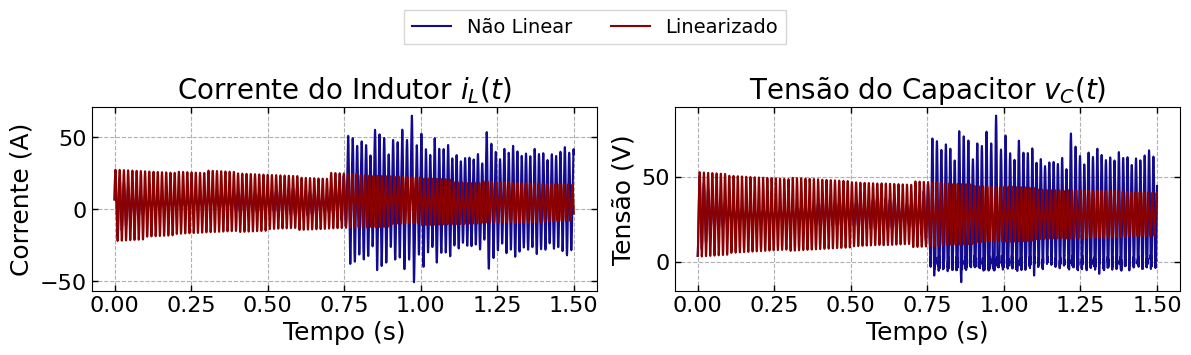

In [34]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

linewidth = 1.5

# Plotando o primeiro gráfico para a corrente do indutor
line1, = axs[0].plot(t, y_nonlinear[0] + params['op']['iL'],
                     linestyle='-', color='#120a8f', linewidth=linewidth, alpha=1)

line2, = axs[0].plot(t, y_linear[0] + params['op']['iL'], linestyle='-',
                     color='#8b0000', linewidth=linewidth, alpha=1)

axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('Corrente (A)', fontsize=18)
axs[0].grid(linestyle='--')
axs[0].set_title('Corrente do Indutor $i_L(t)$', fontsize=20)
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Plotando o segundo gráfico para a tensão do capacitor

axs[1].plot(t, y_nonlinear[1] + params['op']['vC'],
            linestyle='-', color='#120a8f', label='Não linear Transladado', linewidth=linewidth)

axs[1].plot(t, y_linear[1] + params['op']['vC'], linestyle='-',
            color='#8b0000', label='Linearizado', linewidth=linewidth)

axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('Tensão (V)', fontsize=18)
axs[1].grid(linestyle='--')
axs[1].set_title('Tensão do Capacitor $v_C(t)$', fontsize=20)
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Criando uma única legenda para ambos os subplots
fig.legend([line1, line2], ['Não Linear', 'Linearizado'],
           fontsize=14, loc='upper center', bbox_to_anchor=(.5, 1.2), fancybox=False, shadow=False, ncol=2)

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/classic/buck/sim2/op1/result.eps', format='eps', bbox_inches='tight')

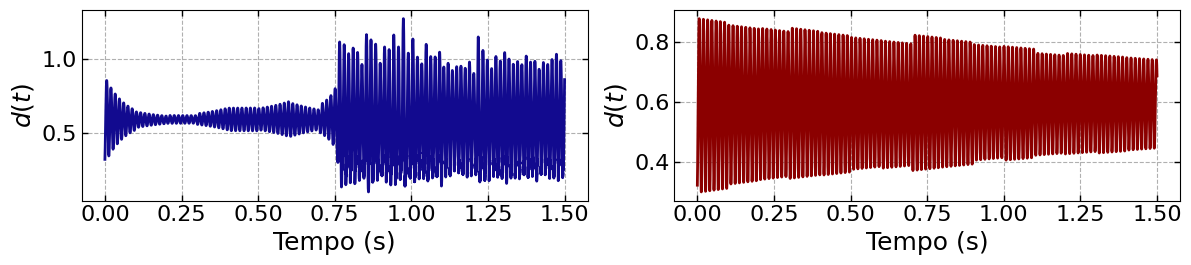

In [35]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 2.75))

linewidth = 2.

line1, = axs[0].plot(t[1:], y_nonlinear[2][1:] + params['op']['d'],
                     linestyle='-', color='#120a8f', linewidth=linewidth, alpha=1)
axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('$d(t)$', fontsize=18)
axs[0].grid(linestyle='--')
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)


line2, = axs[1].plot(t[1:], y_linear[2][1:] + params['op']['d'], linestyle='-',
                     color='#8b0000', label='Linearizado', linewidth=linewidth)

axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('$d(t)$', fontsize=18)
axs[1].grid(linestyle='--')
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)


# fig.legend([line1, line2], ['Não Linear', 'Linearizado'],
#            fontsize=14, loc='upper center', bbox_to_anchor=(.5, 1.2), fancybox=False, shadow=False, ncol=2)

# plt.suptitle(
#     'Duty Cycle $d(t)$', fontsize=18, fontweight='bold')

plt.tight_layout()

plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/classic/buck/sim2/op1/duty-cycle.eps', format='eps', bbox_inches='tight')